In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# 1. 데이터 로드
data = pd.read_csv('data/55285839-9b78-48d8-9f4e-573190ace016_data.csv')

# 2. null값 처리
data = data.dropna()

# rms_xyz 값이 0.03 이상인 데이터만 사용
data = data[data['rms_xyz'] >= 0.03]


# 데이터의 시간 정보를 사용하여 훈련 데이터와 테스트 데이터 나누기
# created_at 유닉스 시간대 컬럼을 기준으로 시계열 정렬
data['created_at'] = pd.to_datetime(data['created_at'], unit='s')
data = data.sort_values(by='created_at')

# 훈련 데이터와 테스트 데이터 분할
split_index = int(len(data) * 0.8)
train_data = data[:split_index]
test_data = data[split_index:]

In [2]:
train_data.head

<bound method NDFrame.head of                                   asset_id          created_at  \
96    55285839-9b78-48d8-9f4e-573190ace016 2024-01-08 15:46:38   
97    55285839-9b78-48d8-9f4e-573190ace016 2024-01-08 17:46:47   
100   55285839-9b78-48d8-9f4e-573190ace016 2024-01-08 23:46:59   
101   55285839-9b78-48d8-9f4e-573190ace016 2024-01-09 01:47:08   
102   55285839-9b78-48d8-9f4e-573190ace016 2024-01-09 03:47:11   
...                                    ...                 ...   
2254  55285839-9b78-48d8-9f4e-573190ace016 2024-07-07 19:52:23   
2255  55285839-9b78-48d8-9f4e-573190ace016 2024-07-07 21:52:26   
2256  55285839-9b78-48d8-9f4e-573190ace016 2024-07-07 23:52:35   
2257  55285839-9b78-48d8-9f4e-573190ace016 2024-07-08 01:52:38   
2258  55285839-9b78-48d8-9f4e-573190ace016 2024-07-08 03:52:47   

      created_at_datetime  temperature     rms_x     rms_y     rms_z  \
96    2024-01-09 00:46:38         19.0  0.016531  0.016529  0.018887   
97    2024-01-09 02:46:47        

In [3]:
# 3. 필요한 특성 선택
train_features = train_data.drop(columns=['asset_id', 'created_at', 'created_at_datetime', 'temperature', 'looseness_health', 'time','misalignment_health', 'asset_health', 'bearing_health', 'imbalance_health'])
test_features = test_data.drop(columns=['asset_id', 'created_at', 'created_at_datetime', 'temperature', 'looseness_health', 'time','misalignment_health', 'asset_health', 'bearing_health', 'imbalance_health'])

# train_features = train_features.loc[:,['vel_crest_factor_x', 'rms_x', 'vel_kurtosis_y','vel_kurtosis_z', 'vel_peak_z','skewness_y','crest_factor_y','vel_skewness_x','vel_rms_xyz','peak_y','peak_x']]
# test_features = test_features.loc[:,['vel_crest_factor_x', 'rms_x', 'vel_kurtosis_y','vel_kurtosis_z', 'vel_peak_z','skewness_y','crest_factor_y','vel_skewness_x','vel_rms_xyz','peak_y','peak_x']]

In [4]:
train_features.columns.to_list()

['rms_x',
 'rms_y',
 'rms_z',
 'rms_xyz',
 'vel_rms_x',
 'vel_rms_y',
 'vel_rms_z',
 'vel_rms_xyz',
 'skewness_x',
 'skewness_y',
 'skewness_z',
 'vel_skewness_x',
 'vel_skewness_y',
 'vel_skewness_z',
 'kurtosis_x',
 'kurtosis_y',
 'kurtosis_z',
 'vel_kurtosis_x',
 'vel_kurtosis_y',
 'vel_kurtosis_z',
 'crest_factor_x',
 'crest_factor_y',
 'crest_factor_z',
 'vel_crest_factor_x',
 'vel_crest_factor_y',
 'vel_crest_factor_z',
 'peak_x',
 'peak_y',
 'peak_z',
 'vel_peak_x',
 'vel_peak_y',
 'vel_peak_z',
 'peak2peak_x',
 'peak2peak_y',
 'peak2peak_z',
 'vel_peak2peak_x',
 'vel_peak2peak_y',
 'vel_peak2peak_z']

In [5]:
train_features.shape , test_features.shape

((1341, 38), (336, 38))

In [6]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(
            input_size=n_features,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
        self.decoder = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=n_features,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        # Encoder
        _, (hidden_n, _) = self.encoder(x)
        
        # Decoder
        decoder_input = hidden_n.repeat(x.size(1), 1, 1).permute(1, 0, 2)
        decoder_output, _ = self.decoder(decoder_input)
        
        return decoder_output

# 모델 초기화
seq_len = 12  # 시퀀스 길이
n_features = 38  # 특성 수
model = LSTMAutoencoder(seq_len, n_features)

In [7]:
# 슬라이딩 윈도우 생성 시 12칸씩 슬라이딩 하려면 사용할 것
# train_features = train_features[:2004]
# test_features = test_features[:492]

In [8]:
# 4. 정규화
scaler = MinMaxScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features) # 테스트 데이터는 fit하면 안됨

# 5. 슬라이딩 윈도우 생성
window_size = seq_len # 2시간 단위를 하루 단위의 status 지표에 맞추기 위해 12 사용
def create_windows(data, window_size):
    return [data[i:i+window_size] for i in range(len(data) - window_size + 1)] # 1칸씩 슬라이딩 (123, 234, 345 ...)
    # return [data[i:i + window_size] for i in range(0, len(data), window_size)] # window_size 만큼 구분지어 슬라이딩 (123, 456, 789 ...)

train_windows = create_windows(train_features_scaled, window_size)
test_windows = create_windows(test_features_scaled, window_size)

# 6. PyTorch 텐서로 변환
train_windows_tensor = torch.tensor(np.array(train_windows), dtype=torch.float32)
test_windows_tensor = torch.tensor(np.array(test_windows), dtype=torch.float32)

In [9]:
train_windows_tensor.shape, test_windows_tensor.shape

(torch.Size([1330, 12, 38]), torch.Size([325, 12, 38]))

In [10]:
# 7. 데이터셋 및 데이터로더 생성
train_dataset = TensorDataset(train_windows_tensor)
test_dataset = TensorDataset(test_windows_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=False)

In [11]:
# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# 학습 루프
num_epochs = 100
best_loss = float('inf')
best_model_state = None

for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch[0])
        loss = criterion(outputs, batch[0])
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}')

    # 최적 모델 업데이트
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()  # 모델의 상태 저장

# 훈련 후 최적 모델 저장
if best_model_state is not None:
    torch.save(best_model_state, '0923_best_model_LSTM_AE.pth')


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Loss: 0.03472825819374742
Epoch 2/100, Loss: 0.02293185866228095
Epoch 3/100, Loss: 0.02266795460034061
Epoch 4/100, Loss: 0.02259086639628754
Epoch 5/100, Loss: 0.022529130029651494
Epoch 6/100, Loss: 0.02246748795313341
Epoch 7/100, Loss: 0.022401936872451154
Epoch 8/100, Loss: 0.022248299490358378
Epoch 9/100, Loss: 0.02184826736380388
Epoch 10/100, Loss: 0.021482244620586302
Epoch 11/100, Loss: 0.021048622944199288
Epoch 12/100, Loss: 0.02086965186806681
Epoch 13/100, Loss: 0.02068062395125896
Epoch 14/100, Loss: 0.02045308801907677
Epoch 15/100, Loss: 0.020119261491607438
Epoch 16/100, Loss: 0.019795811114211876
Epoch 17/100, Loss: 0.01946649645866306
Epoch 18/100, Loss: 0.019185405702808418
Epoch 19/100, Loss: 0.018905776762613305
Epoch 20/100, Loss: 0.018611439654754626
Epoch 21/100, Loss: 0.018392623704228853
Epoch 22/100, Loss: 0.01808859577385692
Epoch 23/100, Loss: 0.01795307749899121
Epoch 24/100, Loss: 0.017944081845852704
Epoch 25/100, Loss: 0.017735089636869

In [36]:
# 11. 모델 평가 (스코어링)
model.load_state_dict(torch.load('0923_best_model_LSTM_AE.pth'))
model.eval()
anomaly_scores = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch[0]
        outputs = model(inputs)
        
        # 재구성 오차로 이상점수 계산
        batch_scores = torch.mean((outputs - inputs) ** 2, dim=(1, 2)).cpu().numpy()
        anomaly_scores.extend(batch_scores)

C:\Users\user\AppData\Local\Temp\ipykernel_2216\2387932225.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('0923_best_model_LSTM_AE.pth'

In [37]:
# 12. 임계값 계산
mean_score = np.mean(anomaly_scores)
std_score = np.std(anomaly_scores)

print(f'평균 스코어: {mean_score:.6f}')
print(f'표준편차: {std_score:.6f}')

# 임계값 설정 (평균 + 임의값 * 표준편차)
threshold = mean_score + 2.576 * std_score
print(f'임계값: {threshold:.6f}')

# 이상 점수 판별
anomalies = anomaly_scores > threshold
print(f'이상 점수 인덱스: {np.where(anomalies)[0]}')

평균 스코어: 0.008661
표준편차: 0.003769
임계값: 0.018371
이상 점수 인덱스: [ 45  47  48 147 156 159]


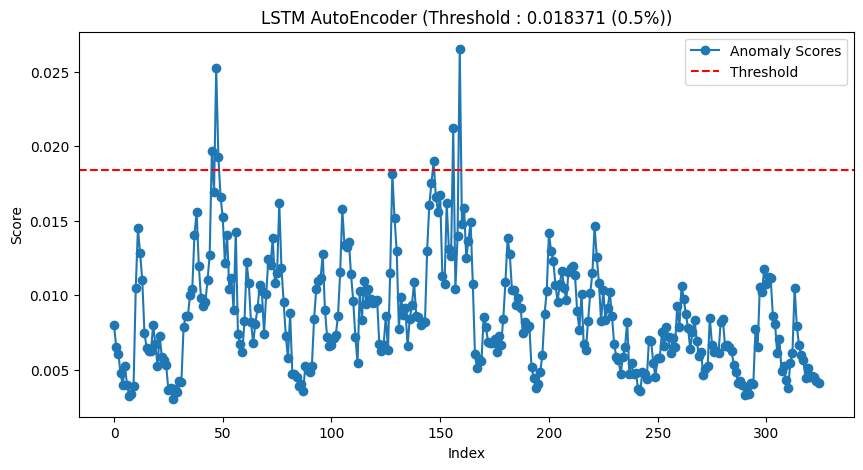

In [38]:
# 13. 인덱스 및 이상 점수 시각화
anomaly_indices = np.where(anomalies)[0]

plt.figure(figsize=(10, 5))
plt.plot(anomaly_scores, label='Anomaly Scores', marker='o')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Index')
plt.ylabel('Score')
plt.title(f'LSTM AutoEncoder (Threshold : {format(threshold, '.6f')} (0.5%))')
plt.legend()
plt.show()

In [39]:
# 이상탐지된 인덱스 비교용
test_data_result=test_data.reset_index(drop=True)
indices = np.where(anomalies)[0].tolist()
test_data_result.loc[indices]

# test_data_result.loc[indices].to_csv("anomaly_transformer_result.csv")


,asset_id,created_at,created_at_datetime,temperature,rms_x,rms_y,rms_z,rms_xyz,vel_rms_x,vel_rms_y,...,peak2peak_z,vel_peak2peak_x,vel_peak2peak_y,vel_peak2peak_z,time,imbalance_health,misalignment_health,looseness_health,bearing_health,asset_health
45,55285839-9b78-48d8-9f4e-573190ace016,2024-07-12 11:57:51,2024-07-12 20:57:51,35.0,0.226364,0.364501,0.171564,0.462099,2.395380,1.298180,...,1.183590,12.93300,8.52209,6.99706,2024-07-13,0.967173,0.989058,0.989058,1.0,0.827017
47,55285839-9b78-48d8-9f4e-573190ace016,2024-07-12 15:58:03,2024-07-13 00:58:03,36.0,0.248876,0.336719,0.184448,0.457537,1.820660,1.736150,...,1.294920,10.85770,11.22990,7.27715,2024-07-14,1.000000,1.000000,1.000000,1.0,1.000000
48,55285839-9b78-48d8-9f4e-573190ace016,2024-07-12 17:58:06,2024-07-13 02:58:06,35.0,0.027954,0.026410,0.020692,0.043670,0.289131,0.232856,...,0.158203,1.75106,1.38186,2.13918,2024-07-14,1.000000,1.000000,1.000000,1.0,1.000000
147,55285839-9b78-48d8-9f4e-573190ace016,2024-07-23 10:11:14,2024-07-23 19:11:14,38.0,0.026686,0.031591,0.021365,0.046547,0.330644,0.258560,...,0.175781,2.10739,1.78938,2.66259,2024-07-24,1.000000,1.000000,1.000000,1.0,1.000000
156,55285839-9b78-48d8-9f4e-573190ace016,2024-07-26 14:14:58,2024-07-26 23:14:58,36.0,0.204030,0.304754,0.164394,0.401907,3.620350,1.853990,...,1.248050,17.81370,10.12280,9.00527,2024-07-27,1.000000,1.000000,1.000000,1.0,0.912593
159,55285839-9b78-48d8-9f4e-573190ace016,2024-07-26 20:15:17,2024-07-27 05:15:17,36.0,0.195316,0.241550,0.145398,0.342980,0.654039,0.669313,...,0.990234,4.95430,4.90449,3.51009,2024-07-28,1.000000,1.000000,1.000000,1.0,1.000000
